<a href="https://colab.research.google.com/github/jacheung/still-learning/blob/master/autocurator2_CNN_v1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import necessary libraries and set up image libraries in Google drive
import numpy as np
import scipy.io
import tensorflow as tf 
from tensorflow import keras
from sklearn.utils import class_weight
import sklearn.model_selection as ms

from google.colab import drive
import glob

import matplotlib.pyplot as plt

# Mount google drive and grab images and labels names 
drive.mount('/content/gdrive')
base_dir = "/content/gdrive/My Drive/Colab data/trialFramesNPY/"
T_class = glob.glob(base_dir + "*touchClass.mat")
frames = glob.glob(base_dir + "*dataset.mat")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:

base_dir = "/content/gdrive/My Drive/Colab data/trialFramesNPY/"
T_class = glob.glob(base_dir + "*touchClass.mat")
frames = glob.glob(base_dir + "*dataset.mat")

In [7]:
T_class

[]

Cut the ends off so we can match them

In [8]:
frame_nums = []
for i in range(len(frames)):
  # print(i)
  frame_nums.append(frames[i][1:-11])
T_class_nums = [];
for i in range(len(T_class)):
  # print(i)
  T_class_nums.append(T_class[i][1:-14])

In [ ]:
T_class_nums[0]

'content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-103_'

match all the label and frame files


In [ ]:
indices = []
for k in range(len(frame_nums)):
  indices.append([i for i, s in enumerate(T_class_nums) if frame_nums[k] in s])

indices = [x for x in indices if x != []]
T_class_reordered = []
for k in range(len(indices)):
    T_class_reordered.append(T_class[indices[k][0]])

# test that this is matched
print(T_class_reordered[0])
print(frames[0])

/content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-35_touchClass.mat
/content/gdrive/My Drive/Colab data/trialFramesNPY/AH0000x000000-35_dataset.mat


load in all of the lables and also count how many data points are in each file. each file represents a trial so for us this could be anywhere between 1 and 4000 data points. most often somewhere between 200-600

In [ ]:
raw_Y_set = []
frame_num_in_Y_set = []
for cnt1 in range(len(frames)):
  tmp2 = scipy.io.loadmat(T_class_reordered[cnt1])
  raw_Y_set.append(tmp2['touchClass'])
  frame_num_in_Y_set.append(len(raw_Y_set[cnt1]))

# build_data 
to generate an image tensor and corresponding label array 

In [ ]:
from psutil import virtual_memory
import sys
import time

def build_data( x_files, y_files) :
  to_del = 0
  start = time.time()

  cnt1 = -1;
  mem_free = 9999

  for k in range(len(y_files)):
    cnt1 = cnt1 + 1
    tmp1 = scipy.io.loadmat(x_files[cnt1])
    tmp2 = scipy.io.loadmat(y_files[cnt1])

    Xtmp = tmp1['finalMat']
    Ytmp = tmp2['touchClass']
    if cnt1==0:
      raw_X = Xtmp
      raw_Y = Ytmp
    else:
      
      # print(raw_Y.shape)
      # print("\r")
      raw_X = np.concatenate((raw_X,Xtmp), axis=0)
      raw_Y = np.concatenate((raw_Y,Ytmp), axis=0)
    if ((time.time() - start) > 2) or cnt1>=len(x_files)-1:# update every 2 seconds or when loop ends
      mem = virtual_memory()
      mem_free = mem.free/1024**3;
      start = time.time()

      # print('\b'* (to_del+2))
      # to_print = ("X shape = " + str(raw_X.shape)+'\n'+
      #             "Y shape = " + str(raw_Y.shape)+'\n'+
      #             str(round(mem_free, 2)) + "GB free"+'\n'+
      #            "iter " + str(cnt1+1) + ' of ' + str(len(y_files)))
      # print(to_print)
      # to_del = len(to_print)
  return raw_X, raw_Y



make a custom class to help load in the data to prevent crashing due to over using RAM 
This class will 
- chunk the files based on the total frames contained in them based on "batch_size" variable 


In [ ]:
class My_Custom_Generator(keras.utils.Sequence) :
  
  def __init__(self, file_trial_list, file_Y_list, num_in_each, batch_size) :
    cnt = 0
    extract_inds = []
    # num_in_each contains the number of frames in each file I am loading, ie
    # for trial/file 1 there are 200 frames , trial/file 2 has 215 frames etc
    for k, elem in enumerate(num_in_each) :
      tot_frame_nums = sum(num_in_each[cnt: k+1]) # used to test if the number of frames in 
      # all these files exceded the "batch_size" limit 
      if tot_frame_nums>batch_size or len(num_in_each)-1 == k: # condition met, these files together 
      # meet the max requirment to load together as a batch 
        extract_inds.append([cnt, k+1])
        cnt = k+1 # reset to the current iter
        if np.diff(extract_inds[-1]) > 1: # if there is more than one file then we want to take off the last file 
        # because it excedes the set number of frames
          extract_inds[-1][-1] = extract_inds[-1][-1]-1
          cnt = cnt-1
    
    file_list_chunks = []
    file_Y_list_chunks = []
    for i, ii in enumerate(extract_inds):
      file_list_chunks.append(file_trial_list[ii[0]:ii[1]])
      file_Y_list_chunks.append(file_Y_list[ii[0]:ii[1]])


    self.file_trial_list = file_trial_list
    self.file_Y_list = file_Y_list
    self.batch_size = batch_size
    self.extract_inds = extract_inds
    self.num_in_each = num_in_each
    self.file_list_chunks = file_list_chunks
    self.file_Y_list_chunks = file_Y_list_chunks
    
    
    # for i, ii in enumerate(extract_inds):
    #   file_list_chunks.append(self.file_trial_list[ii[0]:ii[1]])
    #   file_Y_list_chunks.append(self.file_Y_list[ii[0]:ii[1]])
    

  # def print_ind_frame_info(self) :

  #   for i, ii in enumerate(self.extract_inds):
  #       # num_in_each[extract_inds[i][1]:extract_inds[i][-1]]
  #       tmp1 = self.num_in_each[self.extract_inds[i][0]: self.extract_inds[i][-1]]
  #       print('frames in EACH of these '+str(len(tmp1)) + ' files are '+str(tmp1))
  #       print('   frames in all of these '+ str(len(tmp1)) + ' of these files = ' + 
  #             str(sum(tmp1)) + ' which is less than batch limit of '+str(self.batch_size)+
  #             ' unless a single files exedes this limit ')  
    
  def __len__(self) :
    return len(self.extract_inds)
  
  # def unbunch_files(self, num_2_extract) :
  #   xout2, yout2 = build_data(self.file_list_chunks[num_2_extract], 
  #                         self.file_Y_list_chunks[num_2_extract])
  #   return xout2, yout2
  def __getitem__(self, num_2_extract) :
    raw_X, raw_Y = build_data(self.file_list_chunks[num_2_extract], 
                          self.file_Y_list_chunks[num_2_extract])
    # return xout2, yout2
    rgb_batch = np.repeat(raw_X[..., np.newaxis], 3, -1)
    IMG_SIZE = 96 # All images will be resized to 160x160. This is the size of MobileNetV2 input sizes

    rgb_tensor = tf.cast(rgb_batch, tf.float32) # convert to tf tensor with float32 dtypes
    rgb_tensor = (rgb_tensor/127.5) - 1 # /127.5 = 0:2, -1 = -1:1 requirement for mobilenetV2
    rgb_tensor = tf.image.resize(rgb_tensor, (IMG_SIZE, IMG_SIZE)) # resizing

    self.IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

    samp_weights = np.mean(raw_Y)

    return rgb_tensor, raw_Y
    # batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    # batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    # return np.array([
    #         resize(imread('/content/all_images/' + str(file_name)), (80, 80, 3))
    #            for file_name in batch_x])/255.0, np.array(batch_y)

In [ ]:
# np.mean(raw_Y_2)

0.23432071387084852

# 3) Feature engineering and test/train/validation splits

In [ ]:
batch_size = 2000
my_training_batch_generator = My_Custom_Generator(frames, T_class_reordered, frame_num_in_Y_set,  batch_size)
my_validation_batch_generator = My_Custom_Generator(frames, T_class_reordered, frame_num_in_Y_set,  batch_size)


In [ ]:
# Y vectorization and class weight calculation 
to_del = 0
start = time.time()

cnt1 = -1;
mem_free = 9999
y_files = my_training_batch_generator.file_Y_list
for k in range(len(y_files)):
  cnt1 = cnt1 + 1
  tmp2 = scipy.io.loadmat(y_files[cnt1])

  Ytmp = tmp2['touchClass']
  if cnt1==0:
    raw_Y_2 = Ytmp
  else:
    raw_Y_2 = np.concatenate((raw_Y_2,Ytmp), axis=0)


# 4) Deploy and selection of base model
In this section we're going to use MobileNetV2 as the base model.
We're going to run two variations of the model.  
a. basemodel with frozen layers and output classifer changes   
b. basemodel with final 100 layers unfrozen to optimize prediction 


In [ ]:
# Create base model 

# First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, 
# you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction

# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = 96 # All images will be resized to 160x160. This is the size of MobileNetV2 input sizes
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

feature_batch = base_model.output
print(feature_batch.shape)

# Adding Classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

# Model Stacking
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

print(model.summary())

# Compile model with specific metrics
# Metrics below are for evaluating imbalanced datasets
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name = 'auc')
]

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

9412608/9406464 [==============================] - 0s 0us/step
(None, 3, 3, 1280)
(None, 1280)
(None, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [ ]:
# Fit model with a couple parameters
EPOCHS = 20

# Class imbalance weighting
rebalance = class_weight.compute_class_weight('balanced',
                                  [0, 1], raw_Y_2.flatten())
class_weights = {i : rebalance[i] for i in range(2)}

# Early stopping 
callbacks = [keras.callbacks.EarlyStopping (monitor = 'val_loss',
                                            patience = 2)]

history = model.fit(my_training_batch_generator, epochs=EPOCHS,
              validation_data= my_validation_batch_generator,
              callbacks = callbacks,
              class_weight = class_weights)


Epoch 1/20
49/49 [==============================] - 184s 4s/step - loss: 0.5324 - tp: 14879.0000 - fp: 7206.0000 - tn: 62857.0000 - fn: 7014.0000 - precision: 0.6737 - recall: 0.6796 - auc: 0.8630 - val_loss: 0.4735 - val_tp: 16277.0000 - val_fp: 7048.0000 - val_tn: 63015.0000 - val_fn: 5616.0000 - val_precision: 0.6978 - val_recall: 0.7435 - val_auc: 0.9073
Epoch 2/20
49/49 [==============================] - 48s 987ms/step - loss: 0.4638 - tp: 16581.0000 - fp: 5611.0000 - tn: 64452.0000 - fn: 5312.0000 - precision: 0.7472 - recall: 0.7574 - auc: 0.9315 - val_loss: 0.4800 - val_tp: 19485.0000 - val_fp: 13258.0000 - val_tn: 56805.0000 - val_fn: 2408.0000 - val_precision: 0.5951 - val_recall: 0.8900 - val_auc: 0.9378
Epoch 3/20
49/49 [==============================] - 49s 994ms/step - loss: 0.4226 - tp: 18882.0000 - fp: 9024.0000 - tn: 61039.0000 - fn: 3011.0000 - precision: 0.6766 - recall: 0.8625 - auc: 0.9437 - val_loss: 0.3914 - val_tp: 18776.0000 - val_fp: 6164.0000 - val_tn: 63899.

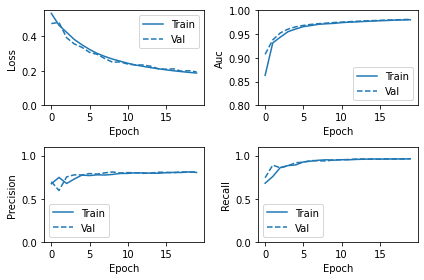

In [ ]:
# Model evaluation
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1.1])

    plt.legend()
    plt.tight_layout()

plot_metrics(history)

# ---- DONE ---- 

In [ ]:
model.predit()

In [ ]:
dmatx,true_y = my_validation_batch_generator.__getitem__(1)

pred_y = model.predict(dmatx)

In [ ]:
from sklearn.metrics import confusion_matrix as cm

cm2 = cm(true_y, pred_y>.5)
# TN FN TP FP 

In [ ]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [ ]:
t2 = true_y*2

pred_binary = pred_y>.5 




create video of data types and sorted by prediction number and print the prediction number on the video to assess if there is a trend in the error type. 

In [ ]:
TP, FP, TN, FN = perf_measure(true_y, pred_binary)

In [ ]:
TP

510

In [ ]:
p2[0:2]

array([[-1],
       [-1]])

In [ ]:
# Fit model with a couple parameters
EPOCHS = 20

# Class imbalance weighting
rebalance = class_weight.compute_class_weight('balanced',
                                  [0, 1], raw_Y_2.flatten())
class_weights = {i : rebalance[i] for i in range(2)}

# Early stopping 
callbacks = [keras.callbacks.EarlyStopping (monitor = 'val_loss',
                                            patience = 2)]

history = model.fit(my_training_batch_generator, epochs=EPOCHS,
              validation_data= my_validation_batch_generator,
              callbacks = callbacks)


#  can use below to see how many positive labels there are
# np.mean(raw_Y_2)

## 1) Data cleaning  
In this section we're going to convert the images to the right channels and dimensions for MobileNetV2. 

a. many of the pre-trained models require 3 channels instead of 1  
b. many of the pre-trained models also require specific image dimensions 

In [ ]:
# a. 3 channel conversion - convert grayscale image (1 channel) to rgb image (3 channel) for pretrained networks
# # REDUCING SIZE OF IMAGE TENSOR AND OTHER ARRAY TO PREVENT CRASHING FOR NOW


# # raw_X = raw_X[0:999, :, :]
# # raw_Y = raw_Y[0:999, :]
# print('raw image size = ' + str(raw_X.shape))  # (64, 224, 224)
# rgb_batch = np.repeat(raw_X[..., np.newaxis], 3, -1)
# print('converted rgb image size = ' + str(rgb_batch.shape))

In [ ]:
# rgb_batch = np.repeat(raw_X[..., np.newaxis], 3, -1)
# IMG_SIZE = 96 # All images will be resized to 160x160. This is the size of MobileNetV2 input sizes

# rgb_tensor = tf.cast(rgb_batch, tf.float32) # convert to tf tensor with float32 dtypes
# rgb_tensor = (rgb_tensor/127.5) - 1 # /127.5 = 0:2, -1 = -1:1 requirement for mobilenetV2
# rgb_tensor = tf.image.resize(rgb_tensor, (IMG_SIZE, IMG_SIZE)) # resizing

# IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)



# 2) Basic EDA  
We're going to verify that the data looks good by eye. 



NameError: ignored

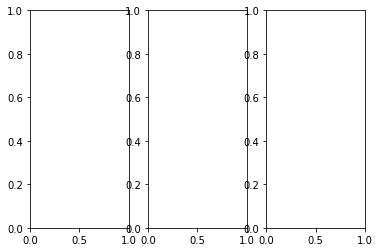

In [ ]:
# Look at the distribution of classes
fig, axs = plt.subplots(1, 3)
axs[0].hist(raw_Y)
axs[0].set_title('class distribution')
axs[0].set_xticks([0,1])
axs[0].set_xticklabels(['neg class', 'pos class'])
axs[0].set_ylabel('number of examples')

# Look at some images of positive and negative
neg_class = [i for i, val in enumerate(raw_Y) if val==0]
pos_class = [i for i, val in enumerate(raw_Y) if val==1]
axs[1].imshow(rgb_tensor[np.random.choice(neg_class,1)[0]])
axs[1].set_title('neg frame ' + str(np.random.choice(neg_class,1)[0]))
axs[2].imshow(rgb_tensor[np.random.choice(pos_class,1)[0]])
axs[2].set_title('pos frame ' + str(np.random.choice(pos_class,1)[0]))
plt.tight_layout()

In [ ]:
# Plot first 25 trials and see what they look like 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(rgb_tensor[i])
    plt.xlabel(str(raw_Y[i]))
plt.show()

#3) Feature engineering and test/train splits

In [ ]:
#3) Feature engineering and train test split

X_train,X_test,Y_train,Y_test = ms.train_test_split(rgb_tensor.numpy(), raw_Y , test_size=0.2)
X_train,X_val,Y_train,Y_val= ms.train_test_split(X_train, Y_train, test_size=0.2)

print('train = ' + str(X_train.shape[0]))
print('test = ' + str(X_val.shape[0]))
print('validation = ' + str(X_test.shape[0]))

In [ ]:
rebalance

array([0.65301492, 2.13382757])

In [ ]:
# Model prediction

prediction = model.predict(X_test)


#5) Hyperparameter tuning of best base model 

In [ ]:
# Fine-tuning model by unfreezing layers and allowing them to be trainable

model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

# Compile model with specific metrics
# Metrics below are for evaluating imbalanced datasets
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name = 'auc')
]

# compile model with a much slower learning rate 
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)


In [ ]:
# Fit model with class imbalance weighting

rebalance = class_weight.compute_class_weight('balanced',
                                  np.unique(Y_train), Y_train.flatten())
class_weights = {i : rebalance[i] for i in range(2)}

history = model.fit(X_train, Y_train, epochs=10,
              validation_data=(X_val, Y_val),
              class_weight=class_weights)

In [ ]:
pred_Y = model.predict(rgb_tensor)




In [ ]:
fail_pred = raw_Y == pred_Y
# tmp3 = 
tmp3 = np.argwhere(fail_pred==False)

tmp3[:, 0]
# print(fail_pred)
print(raw_Y[1:10])
print(pred_Y[1:10])

In [ ]:
import numpy as np

num_in_each = [1, 233, 430, 2008, 600, 1, 40]
max_batch_size = 600
cnt = 0
extract_inds = []
# num_in_each contains the number of frames in each file I am loading, ie
# for trial/file 1 there are 200 frames , trial/file 2 has 215 frames etc
for k, elem in enumerate(num_in_each) :
  tot_frame_nums = sum(num_in_each[cnt: k+1]) # used to test if the number of frames in 
  # all these files exceded the "max_batch_size" limit 
  if tot_frame_nums>max_batch_size or len(num_in_each)-1 == k: # condition met, these files together 
  # meet the max requirment to load together as a batch 
    print(tot_frame_nums)
    print(cnt, k+1)
    extract_inds.append([cnt, k+1])
    cnt = k+1 # reset to the current iter
    if np.diff(extract_inds[-1]) > 1: # if there is more than one file then we want to take off the last file 
    # because it excedes the set number of frames
      extract_inds[-1][-1] = extract_inds[-1][-1]-1
      cnt = cnt-1